# Import all the things required for datalab and authenticate

In [1]:
# Import packages including some Data Lab (dl) specific ones.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import gridspec
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
%matplotlib notebook

from dl import authClient, queryClient

from cStringIO import StringIO  #C script to handle string format
from astropy.table import Table
print 'Done importing'

token = authClient.login('anonymous')
print 'Done getting token'

Done importing
Done getting token


# Write the SQL query

brickid, objid together uniquely identifies each object

In [2]:
# Write query statement (adql)
query = """SELECT brickid, objid, ra, dec, g_r, r_z, z_w1, w1_w2, type 
         FROM ls_dr3.tractor_primary 
         WHERE (decam_nobs_2>1 and decam_nobs_3>1 and decam_nobs_5>1 
                and g != 'nan' and g != 'inf' and r != 'nan' and r != 'inf' and z != 'nan' and z != 'inf'
                and z_w1 != 'nan' and w1_w2 != 'nan')
         LIMIT 10"""

# ra, dec      = position of targets
# g,r,z,w1,w2  = photometry in individual bands in AB magnitudes
# g_r, r_z     = pre-computed optical colors g-r and r-z in AB magnitudes
# z_w1         = pre-computed z-band to WISE w1 color in AB mag
# w1_w2        = pre-computed w1-w2 WISE color
# decam_nobs_X = number of observations in bands g (2), r (3) & z (5)
# type         = object type (PSF, SIMP, EXP, DEV, COMP)
#
# WHERE: requirement that there are more than 1 (i.e., at least 2) observation in each DECaLS band

# Make the query

In [5]:
# Call query manager
try:
    response = queryClient.query(token, sql=query, fmt='csv')
except Exception as e:
    print e.message
    raise

In [6]:
trac = Table.read(StringIO(response), format='csv')  #dictionary
print 'Nb of galaxies:',len(trac)
print trac

Nb of galaxies: 10
brickid objid       ra           dec       ...    z_w1       w1_w2    type
------- ----- ------------- -------------- ... ---------- ----------- ----
 337535    14 351.878517888 0.875446854945 ...    4.71467   -0.541593  DEV
 337535   261 351.877009688 0.879206143277 ...  -0.597368    0.143746  EXP
 336095  5415 351.881743036 0.873965289594 ...   0.236814   -0.380435  EXP
 337535    11 351.881838532 0.875649467072 ...   0.578134   -0.212336  EXP
 337535   440 351.872104917 0.885804317182 ...  -0.125348 -0.00694824  EXP
 337535   421 351.881876955 0.885144147496 ...    1.26702   -0.501703 SIMP
 337535   420 351.880477372  0.88578615979 ... -0.0928649   -0.213542  DEV
 336095  3651 351.891880048 0.788387404941 ...    1.07265    -0.44399  PSF
 336095  3578 351.893419187 0.784217016678 ...    2.52866  -0.0988768 SIMP
 336095  3594 351.898346128 0.784662159662 ...    1.24628   -0.383669  EXP


# Define a class for each object with its cutouts

In [7]:
class FullObjectInfoWithCutouts():
    """
    Class to contain all of the information for the object along with its cutout
    """
    
    def __init__(self, brickid, objid, ra, dec, g_r, r_z, z_w1, w1_w2):
        self.brickid = brickid
        self.objid = objid
        self.ra = ra
        self.dec = dec
        self.g_r = g_r
        self.r_z = r_z
        self.z_w1 = z_w1
        self.w1_w2 = w1_w2
        
        self.select_object_cutouts()
        
    def __repr__(self):
        output_string = "(%i-%i) \nRA:%f DEC:%f \ng-r %f \nr-z %f \nz-w1 %f \nw1-w2 %f" \
                        % (self.brickid, self.objid, self.ra, self.dec, self.g_r, self.r_z, self.z_w1, self.w1_w2)
        return output_string
        
    def select_object_cutouts(self):
        """
        Find the decals and wise cutouts
        """
        de_cutout_url = \
            'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=decals-dr3&zoom=15&bands=grz' \
            % (self.ra, self.dec)
        decals_cutout = plt.imread(download_file(de_cutout_url,cache=False,show_progress=False,timeout=120))
        
        wi_cutout_url = \
            'http://legacysurvey.org/viewer/jpeg-cutout/?ra=%g&dec=%g&layer=unwise-w1w2&zoom=15' \
            % (self.ra, self.dec)
        wise_cutout = plt.imread(download_file(wi_cutout_url,cache=False,show_progress=False,timeout=120))
        
        self.decals_cutout = decals_cutout
        self.wise_cutout = wise_cutout

# Make the CMD

In [8]:
object_list = [FullObjectInfoWithCutouts(trac['brickid'][i], trac['objid'][i], trac['ra'][i], \
               trac['dec'][i], trac['g_r'][i], trac['r_z'][i], trac['z_w1'][i], trac['w1_w2'][i]) \
               for i in range(len(trac))]

print len(object_list)

10


<IPython.core.display.Javascript object>


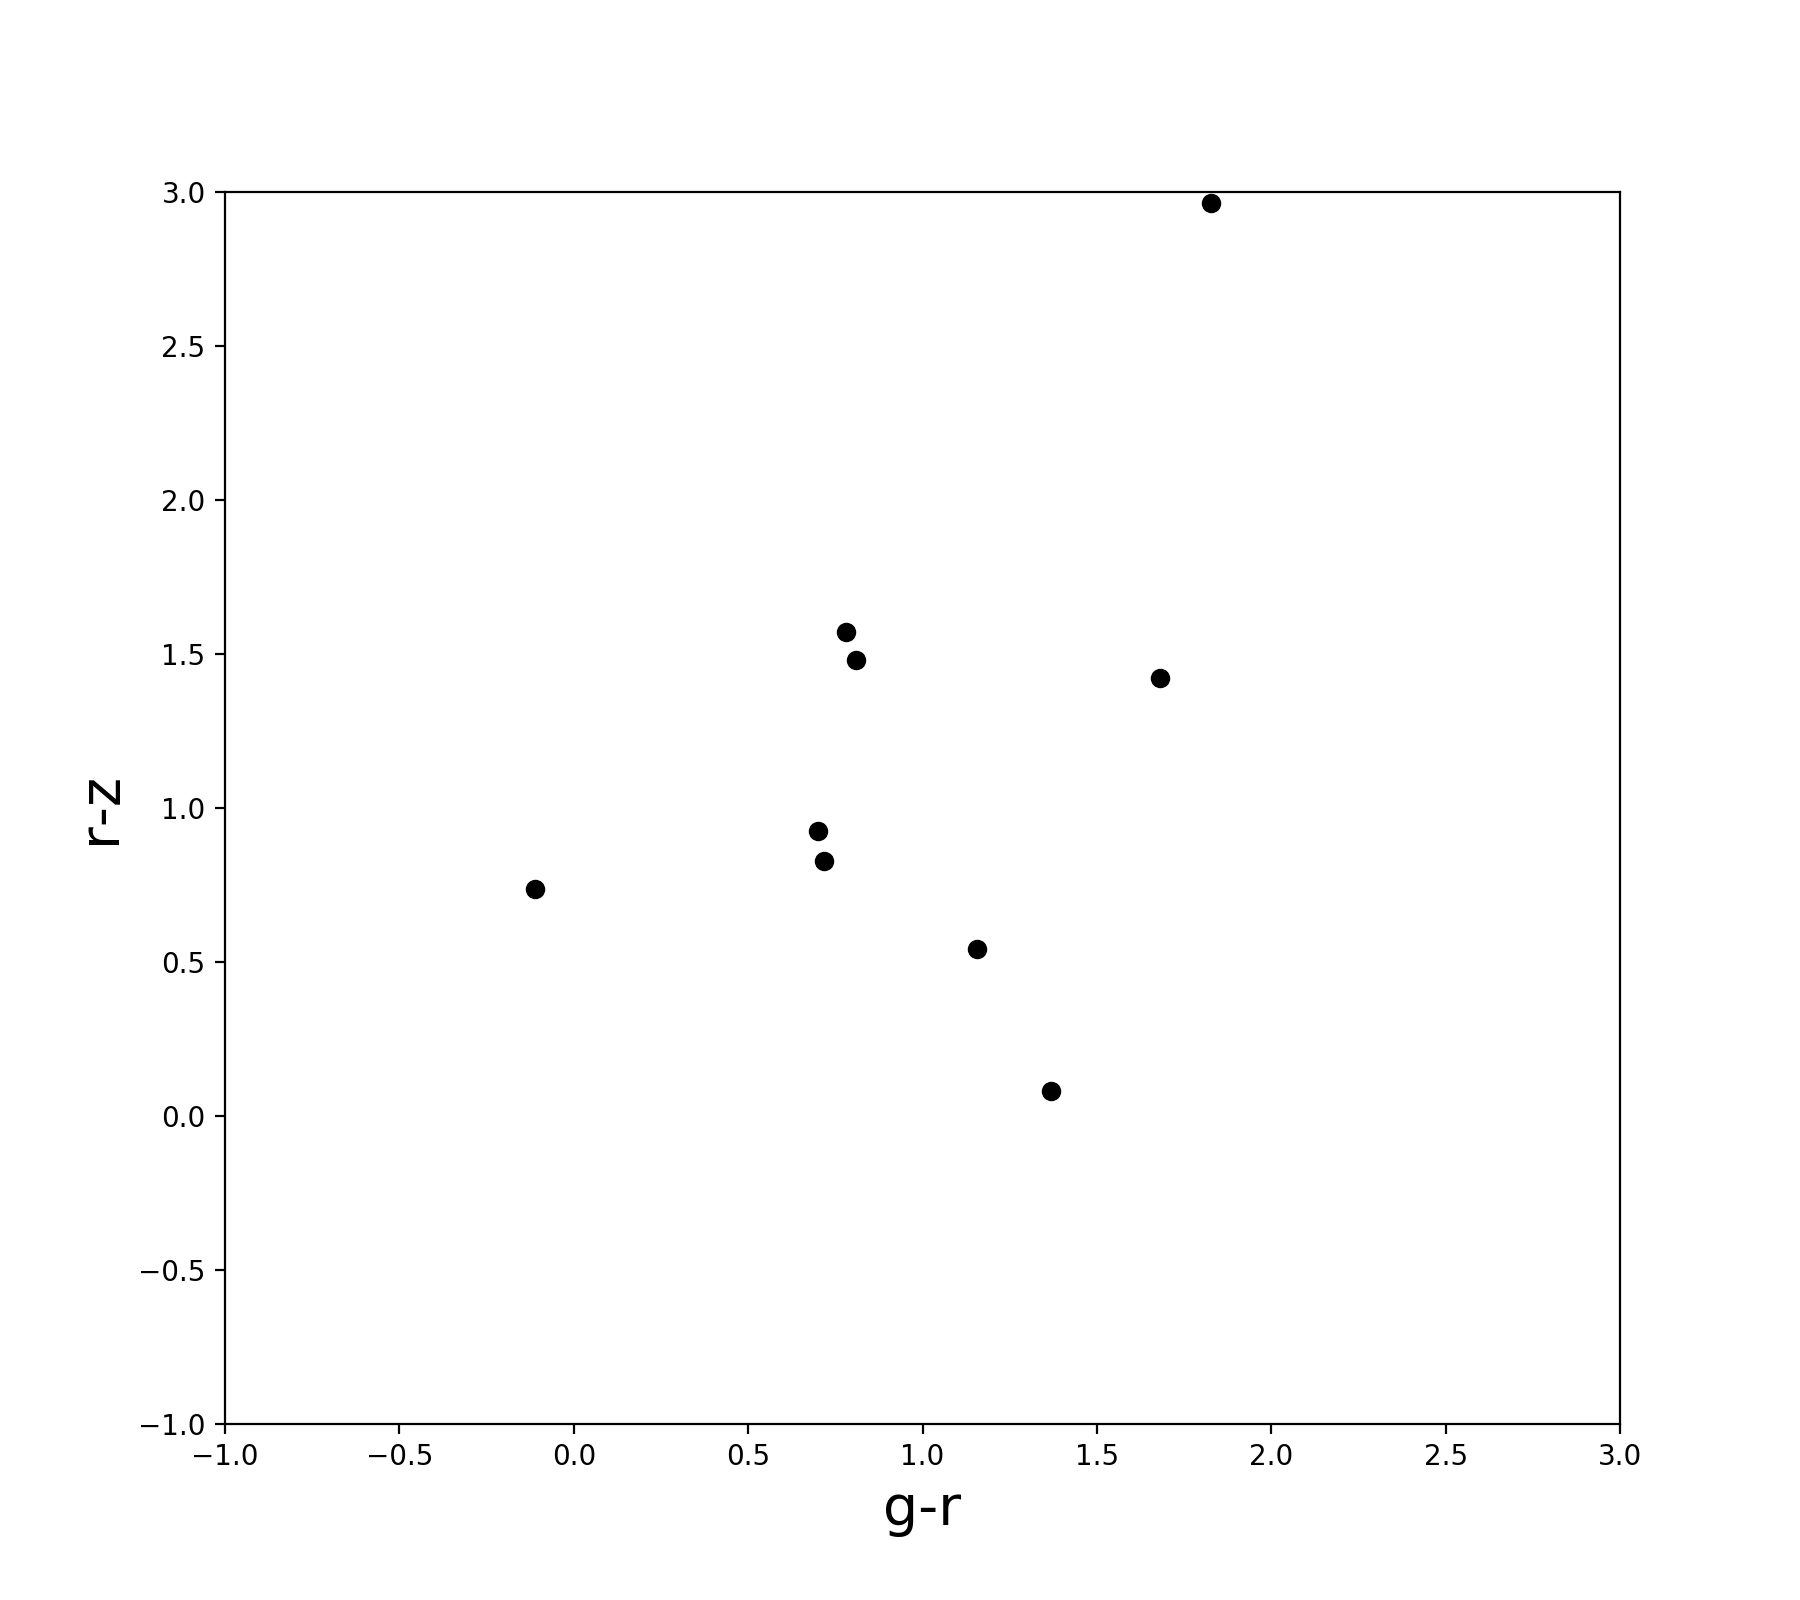

In [54]:
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
plt.plot(trac['r_z'], trac['g_r'], 'ok')
ax1.set_xlim(-1, 3)
ax1.set_ylim(-1, 3)
ax1.set_ylabel('r-z',fontsize=20)
ax1.set_xlabel('g-r',fontsize=20)

# Return the index of the point clicked
Later, write a distance function to return the indicies of all the nearby points

In [59]:
test_id = 0
def onpick(event):
    test_id = event.xdata
    return event.ind

fig.canvas.mpl_connect('pick_event', onpick)

8

<IPython.core.display.Javascript object>


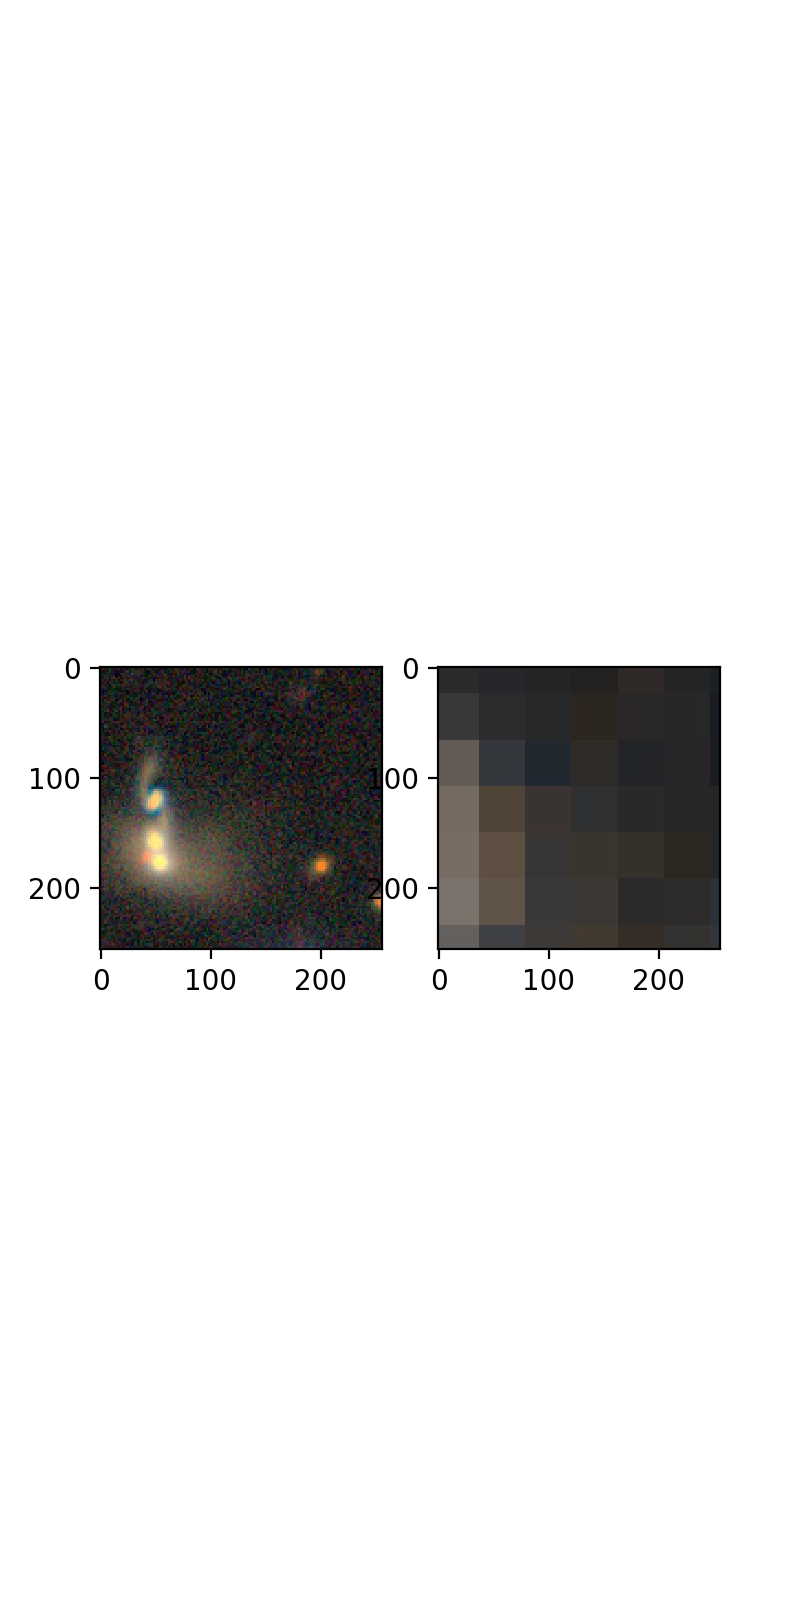

In [68]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(1,2,1)
ax.imshow(object_list[0].decals_cutout)
ax = fig.add_subplot(1,2,2)
ax.imshow(object_list[0].wise_cutout)